In [0]:
import keras

Using TensorFlow backend.


In [0]:
#@title 
    !git clone https://bitbucket.org/jadslim/german-traffic-signs

    !ls german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.
signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [0]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline

Clone the bitbucket german traffic signs repository and import numpy,matplotlib,keras models(sequential),keras optimizers(Adam),keras layers->Dense,Flatten,Dropout,Conv2D,MaxPooling2D,random,pickle,pandas,cv2

In [0]:
    np.random.seed(0)

    # TODO: Implement load the data here.
    with open('german-traffic-signs/train.p', 'rb') as f:
        train_data = pickle.load(f)
    with open('german-traffic-signs/valid.p', 'rb') as f:
        val_data = pickle.load(f)
    # TODO: Load test data
    with open('german-traffic-signs/test.p', 'rb') as f:
        test_data = pickle.load(f)
     
    X_train, y_train = train_data['features'], train_data['labels']
    X_val, y_val = val_data['features'], val_data['labels']
    X_test, y_test = test_data['features'], test_data['labels']
     
    #already 4 dimensional
    print(X_train.shape)
    print(X_test.shape)
    print(X_val.shape)

    # STOP: Do not change the tests below. Your implementation should pass these tests. 
    assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
    assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
    assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
    assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


Start preprocessing the dataset : load the pickle files(Sequential data)and read the train data,validation data,test data in the form of objects

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


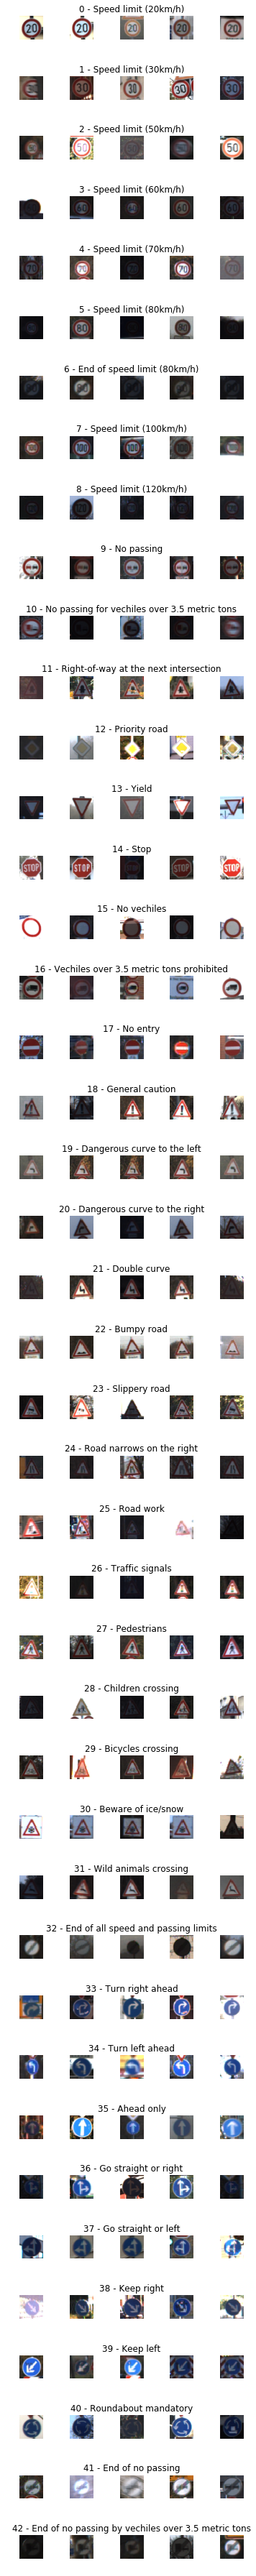

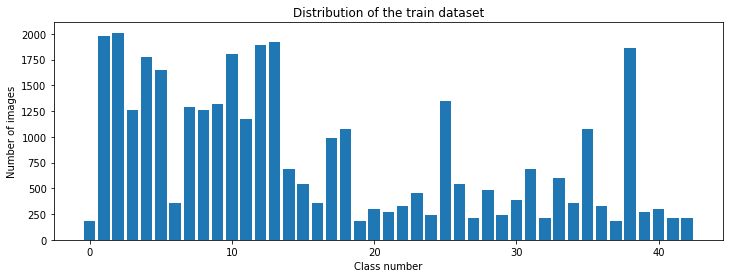

In [0]:
      data = pd.read_csv('german-traffic-signs/signnames.csv')
      
      num_of_samples=[]
     
      cols = 5
      num_classes = 43
     
      fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
      fig.tight_layout()
     
      for i in range(cols):
          for j, row in data.iterrows():
            x_selected = X_train[y_train == j]
            axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
            axs[j][i].axis("off")
            if i == 2:
              axs[j][i].set_title(str(j) + " - " + row["SignName"])
              num_of_samples.append(len(x_selected))
              
      
      print(num_of_samples)
      plt.figure(figsize=(12, 4))
      plt.bar(range(0, num_classes), num_of_samples)
      plt.title("Distribution of the train dataset")
      plt.xlabel("Class number")
      plt.ylabel("Number of images")
      plt.show()

Read the csv file containing mapping between indexes and class names for the 43 classes.Then display the images and plot the bar graph showing dataset distribution i.e number of images in each category of class.

(32, 32, 3)
36


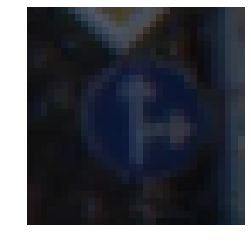

In [0]:
    import cv2
     
    plt.imshow(X_train[1000])
    plt.axis("off")
    print(X_train[1000].shape)
    print(y_train[1000])

    def grayscale(img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

Convert the image to grayscale

(32, 32)
(32, 32)
(34799, 32, 32)


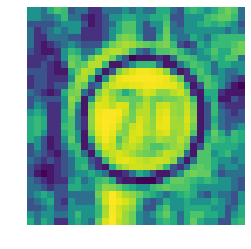

In [0]:
    img = grayscale(X_train[1000])
    plt.imshow(img)
    plt.axis("off")
    print(img.shape)

    def equalize(img):
        img = cv2.equalizeHist(img)
        return img

    img = equalize(img)
    plt.imshow(img)
    plt.axis("off")
    print(img.shape)

    def preprocess(img):
        img = grayscale(img)
        img = equalize(img)
        img = img/255
        return img
    
    X_train = np.array(list(map(preprocess, X_train)))
    X_test = np.array(list(map(preprocess, X_test)))
    X_val = np.array(list(map(preprocess, X_val)))
     
    plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
    plt.axis('off')
    print(X_train.shape)

X_train.shape is a tuple/list containing 4 parameters (number of images,image_width,image_height,number of chanels in a image)

y_train contains label used for the image in X_train at the same index.

In [0]:
    X_train = X_train.reshape(34799, 32, 32, 1)
    X_test = X_test.reshape(12630, 32, 32, 1)
    X_val = X_val.reshape(4410, 32, 32, 1)

reshape X_train to 1 channel image

(15, 32, 32, 1)


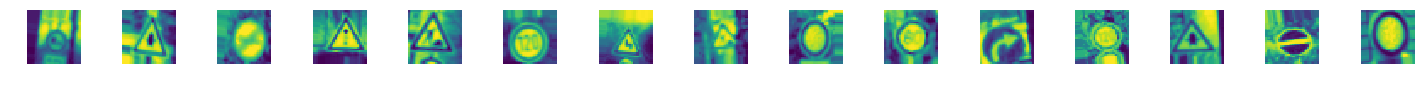

In [0]:
    from keras.preprocessing.image import ImageDataGenerator
     
    datagen = ImageDataGenerator(width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.2,
                                shear_range=0.1,
                                rotation_range=10.)
     
    datagen.fit(X_train)

    # for X_batch, y_batch in
     

    batches = datagen.flow(X_train, y_train, batch_size = 15)
    X_batch, y_batch = next(batches)
     
    fig, axs = plt.subplots(1, 15, figsize=(20, 5))
    fig.tight_layout()
    
    for i in range(15):
        axs[i].imshow(X_batch[i].reshape(32, 32))
        axs[i].axis("off")
     
    print(X_batch.shape)



Perform augmentation on each image using ImageDataGenerator class,

followed by fit(), it computes quantites required for featurewise normalization, 

followed by flow(), it provide the model on batches with real-time data augmentation

In [0]:
    y_train = to_categorical(y_train, 43)
    y_test = to_categorical(y_test, 43)
    y_val = to_categorical(y_val, 43)

    # create model
     
    def modified_model():
      model = Sequential()
      model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
      model.add(Conv2D(60, (5, 5), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      
      model.add(Conv2D(30, (3, 3), activation='relu'))
      model.add(Conv2D(30, (3, 3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2, 2)))
      
      model.add(Flatten())
      model.add(Dense(500, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(43, activation='softmax'))
      
      model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
      return model

    model = modified_model()
    print(model.summary())
     
    history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                                steps_per_epoch=2000,
                                epochs=10,
                                validation_data=(X_val, y_val), shuffle = 1)

to_categorical() - is used to convert a class vector(integers) to binary class matrix

define the model and its layer in modified_model() and train the model using below steps:
1. sequential() to define the model
2. add() to add layers of Conv2D(no. of filters,size of each filter, input shape of image, activation function)
3. you can add more conv layers to reduce overfitting.
4. MaxPooling2D() to add pooling layer with pool_size of 2,2
5. can add as many pooling layers as needed , it will reduce the size of the feature map(check this---)
6. Flatten() to add a flatten layer, it will flatten the feature vector.
7. Dense() to add a dense layer, with no. of filters as first parameter.
8. Dropout() to add a dropout layer, it will reduce the number of images from the dataset while training to reduce overfitting.
9. compile the model with Adam optimizer,loss and metrics data.
10. call model.fit_generator(datagen.flow())- to train the model with images using image batches,epochs,validation data etc


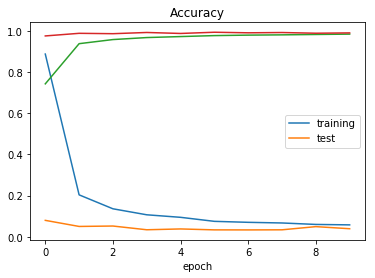

In [0]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('epoch')
     
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['training','test'])
    plt.title('Accuracy')
    plt.xlabel('epoch')
     
    # TODO: Evaluate model on test data
    score = model.evaluate(X_test, y_test, verbose=0)

Plot the training data loss and accuracy, validation loss and accuracy, then evaluate the model on test data for loss and accuracy.

Test score: 0.10266487191279068
Test accuracy: 0.9769596199713713
(32, 32)
predicted sign: [34]


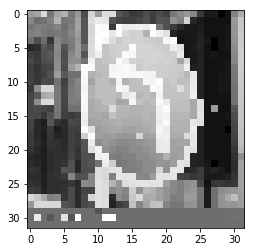

In [0]:
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
     
    #predict internet number
    import requests
    from PIL import Image
    url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
     
    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocess(img)
    plt.imshow(img, cmap = plt.get_cmap('gray'))
    print(img.shape)
    img = img.reshape(1, 32, 32, 1)
     
    print("predicted sign: "+ str(model.predict_classes(img)))

Finally print the prediction on test data.It will output the class id of the sign in image for the corresponding label.